<h2>More Linear Regression Models</h2>

The basic Linear Regression model we discussed previously is very limited in that it requires the features and the target to have a linear correlation to perform well.

In practice, we commonly observe nonlinear correlation between features and targets. Therefore, we need more advance models. In this module, we will discuss variant of linear regression that allow nonlinearity. As discussed in the previous module, the simplest way to check for nonlinearity in data is to use scatter plots. Nonlinearity results in a curvy pattern, whereas linear correlations appear as a straight line pattern on the plots.

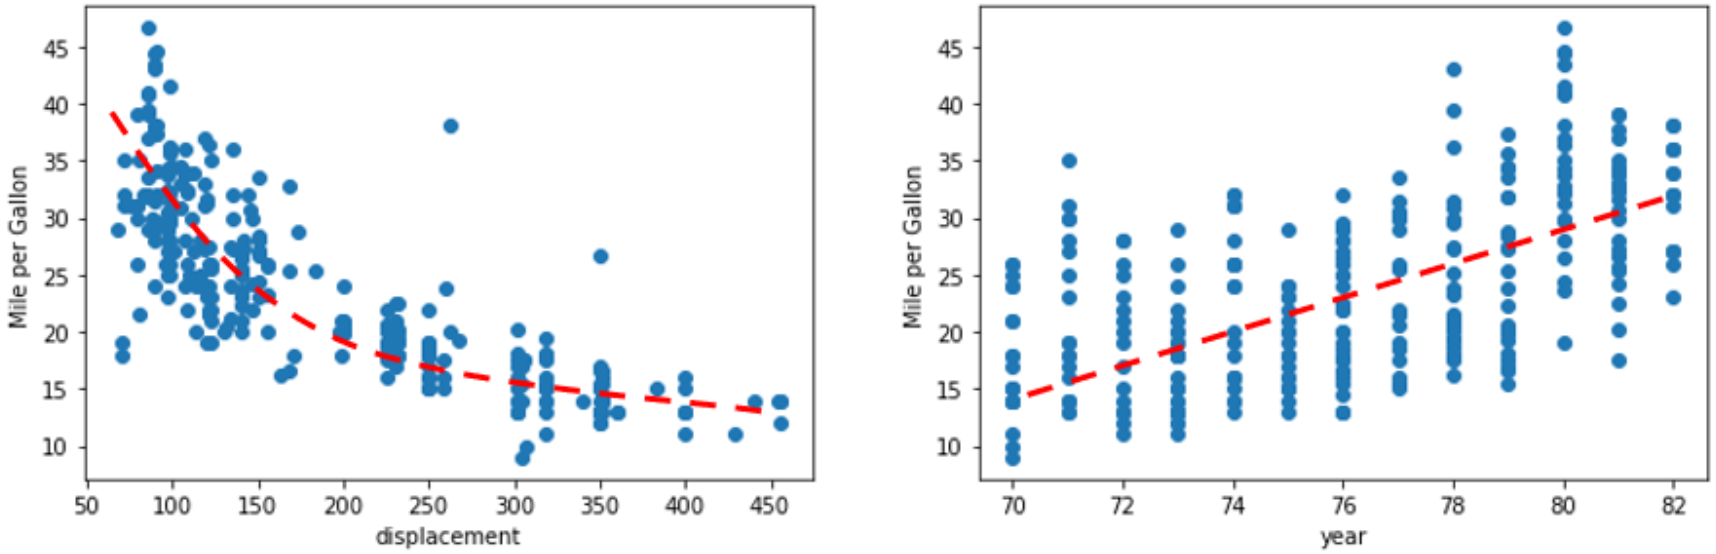

<h3> Polynomial Regression </h3>

We brieftly talked about adding a squared version of the features to the model through a pipeline previously. This is a form of 2nd-degree polynomial regression model. In such cases, the equation becomes

$\hat{y} = \beta_0 + \beta_{11} x_1 + \beta_{12} x_2 \dots + \beta_{1k} x_k + \beta_{21} x^2_1 + \beta_{22} x^2_2 \dots + \beta_{2k} x^2_k$

However, 2nd-degree polynomial also includes features that are called "interactions". In short, (2nd degree) interactions are products of two features, for example, the interaction between $x_1$ and $x_2$ is $x_1 \times x_2$. The equation in such cases becomes

$\hat{y} = \beta_0 + \beta_{11} x_1 + \beta_{12} x_2 \dots + \beta_{1k} x_k + \beta_{21} x^2_1 + \beta_{22} x^2_2 \dots + \beta_{2k} x^2_k + \beta_{112}x_1x_2 + + \beta_{113}x_1x_3 + \dots + \beta_{(k-1)k}x_{k-1}x_k$

<h4>Why Interaction</h4>

Adding interaction may improve a model performance where the original features do not have or have a weak correlation with the target, but their combination has a strong correlation.

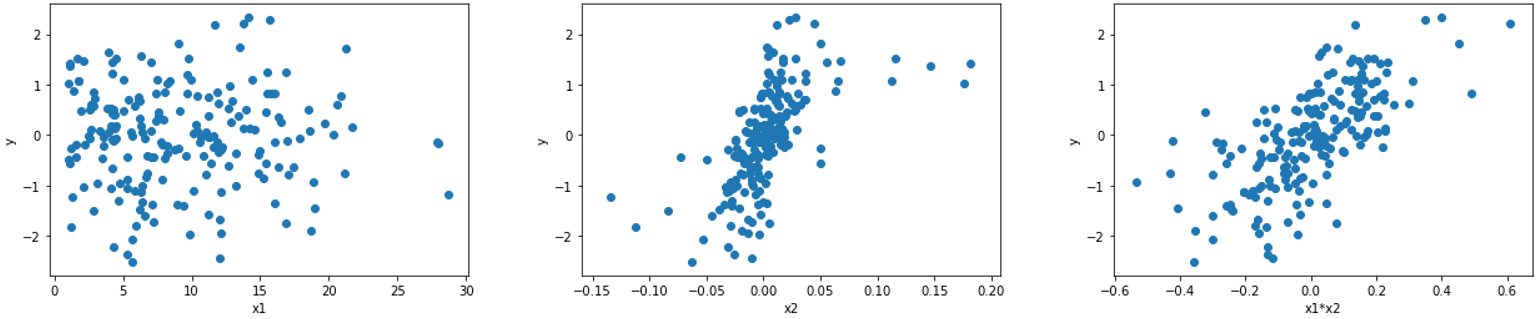

<h4>Adding polynomial features in SKLearn</h4>

To add polynomial features to the data, we use PolynomialFeatures - remember to set the polynomial degree

For example, to add 2nd-degree features

In [1]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
X = np.array([[0, 1],
              [2, 3],
              [4, 5]])

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_poly

array([[ 0.,  1.,  0.,  0.,  1.],
       [ 2.,  3.,  4.,  6.,  9.],
       [ 4.,  5., 16., 20., 25.]])

Or 3rd-degree features

In [2]:
poly_3 = PolynomialFeatures(degree=3, include_bias=False)

X_poly_3 = poly_3.fit_transform(X)

X_poly_3

array([[  0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.],
       [  2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

<h3>Adding Polynomial Features in a Pipeline</h3>

In a real analysis, we can add the new features as another step in our pipeline, for example, in the auto-mpg data

In [4]:
import pandas as pd

auto = pd.read_csv('auto-mpg.csv')

from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(auto):
    train_set = auto.loc[train_index]
    test_set = auto.loc[test_index]
    
trainX = train_set.drop('mpg',axis=1)
trainY = train_set['mpg']
testX = test_set.drop('mpg',axis=1)
testY = test_set['mpg']

trainX.shape, testX.shape, trainY.shape, testY.shape

((298, 7), (100, 7), (298,), (100,))

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#pipeline for numeric features
#we need to impute horsepower
num_cols = trainX.columns[:-1] #because the last column is class
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2)),
    ('standardize', StandardScaler())
])

#pipeline for class features
cat_cols = trainX.columns[-1:] #because the last column is class
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

#full pipeline - combine numeric and class pipelines
full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

In [6]:
trainX_poly2 = full_pipeline.fit_transform(trainX)
trainX_poly2.shape

(298, 31)

After adding polynomial features, we fit a linear regression model like normal

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

poly_reg = LinearRegression()
poly_reg.fit(trainX_poly2,trainY)

mse_lr_cv = - cross_val_score(poly_reg, trainX_poly2, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(poly_reg, trainX_poly2, trainY, cv=5, scoring='r2')

print('Poly Reg 2nd-degree Train R2: ', poly_reg.score(trainX_poly2,trainY))
print('Poly Reg 2nd-degree CV MSE: ', mse_lr_cv.mean())
print('Poly Reg 2nd-degree CV R2: ', r2_lr_cv.mean())

Poly Reg 2nd-degree Train R2:  0.8000350958113326
Poly Reg 2nd-degree CV MSE:  17.70694710406972
Poly Reg 2nd-degree CV R2:  0.7064347089744618


As you can see, the training R2 is much better than the cross-validation R2. What does this means?

It turns out, adding polynomial features is a very easy way to overfit the training data; the higher the degree, the easier it gets to overfit.

Let's see a 3rd-degree polynomial model

In [8]:
num_pipeline_2 = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=3)),
    ('standardize', StandardScaler())
])

#full pipeline - combine numeric and class pipelines
full_pipeline_2 = ColumnTransformer([
    ('numeric', num_pipeline_2, num_cols),
    ('class', cat_pipeline, cat_cols)
])

trainX_poly3 = full_pipeline_2.fit_transform(trainX)
trainX_poly3.shape

(298, 87)

In [9]:
poly_reg.fit(trainX_poly3,trainY)

mse_lr_cv = - cross_val_score(poly_reg, trainX_poly3, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(poly_reg, trainX_poly3, trainY, cv=5, scoring='r2')

print('Poly Reg 3rd-degree Train R2: ', poly_reg.score(trainX_poly3,trainY))
print('Poly Reg 3rd-degree CV MSE: ', mse_lr_cv.mean())
print('Poly Reg 3rd-degree CV R2: ', r2_lr_cv.mean())

Poly Reg 3rd-degree Train R2:  0.8482560536977268
Poly Reg 3rd-degree CV MSE:  85.82578213169059
Poly Reg 3rd-degree CV R2:  -0.41270046587422227


So, training R2 is even higher than before, and cross-validation R2 is negative now, all of which suggests this model is overfitting the data even more severely. 

Let's try a regular linear model without polynomial features

In [10]:
num_pipeline_3 = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

#full pipeline - combine numeric and class pipelines
full_pipeline_3 = ColumnTransformer([
    ('numeric', num_pipeline_3, num_cols),
    ('class', cat_pipeline, cat_cols)
])

trainX_ln = full_pipeline_3.fit_transform(trainX)
trainX_ln.shape

(298, 9)

In [11]:
linear_reg = LinearRegression()
linear_reg.fit(trainX_ln,trainY)

mse_lr_cv = - cross_val_score(poly_reg, trainX_ln, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(poly_reg, trainX_ln, trainY, cv=5, scoring='r2')

print('Linear Reg Train R2: ', linear_reg.score(trainX_ln,trainY))
print('Linear Reg CV MSE: ', mse_lr_cv.mean())
print('Linear Reg CV R2: ', r2_lr_cv.mean())

Linear Reg Train R2:  0.8172751189834604
Linear Reg CV MSE:  12.138420248599349
Linear Reg CV R2:  0.8030148839899887


<h5>Result Recap</h5>

|Model    |Training R2|Training CV R2|
|---------|-----------|--------------|
|Linear   |0.817      |0.803         |
|Degree 2 |0.800      |0.706         |
|Degree 3 |0.848      |-0.413        |

So, overfitting becomes more severe with more degree we add.

<h3>Model Complexity and Overfitting</h3>

Recall once more, a linear regression model has the equation

$\hat{y} = \beta_0 + \beta_1 𝑥_1 + \beta_2 𝑥_2 + \dots + \beta_𝑘 𝑥_𝑘$

We have not discussed how a linear regression model is trained. In general, there are multiple ways, but they all try to determine a set of coefficient 𝜷=[𝛽_0…𝛽_𝑘] with the same training objective of minimize the MSE in training data:

$\min_{data} \sum(y_i-\hat{y_i})^2$

This is why a linear model is also called an Ordinary Least Squares model. So, more polynomial features means more coefficients in 𝜷, and it is easier to fit an equation to obtain less training MSE

But it also means the models are more prone to overfitting without proper control of which values 𝜷 can get

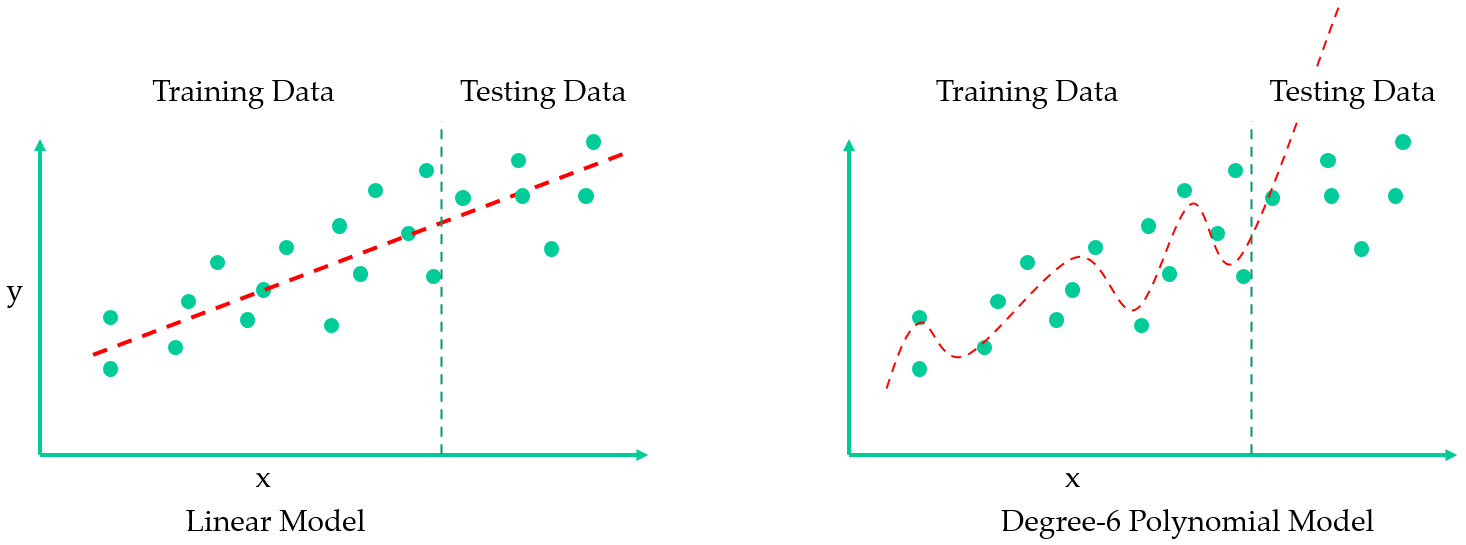

<h3>Regularization</h3>

To effectively control 𝜷 and prevent them from overfitting the data, we use a method that is called regularization. Regularized linear models add more conditions to the training objective to prevent 𝜷 from freely changing to fit the training data. There are three types we will learn in this module
- Ridge Regression
- LASSO
- Elastic-Net



<h3>Ridge Regression</h3>

Add the sum of squares of coefficients to the training objective

$min_\beta \sum_{𝑑𝑎𝑡𝑎}(𝑦−\hat{y})^2 +\alpha \sum \beta_𝑖^2 $

where 𝛼 is complexity term. Larger 𝛼 means the model is more 	robust, but also mean 𝜷 is controlled stricter. 

In SKLearn, we use the Ridge class, also from the sklearn.linear_model module. A default Ridge regression model has $\alpha=1$.

Let's try the model on the 2nd-degree polynomial data

In [16]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge()

ridge_reg.fit(trainX_poly2,trainY)

mse_lr_cv = - cross_val_score(ridge_reg, trainX_poly2, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(ridge_reg, trainX_poly2, trainY, cv=5, scoring='r2')

print('Poly Reg Train R2: ', ridge_reg.score(trainX_poly2,trainY))
print('Poly Reg CV MSE: ', mse_lr_cv.mean())
print('Poly Reg CV R2: ', r2_lr_cv.mean())

Poly Reg Train R2:  0.8713112281784806
Poly Reg CV MSE:  9.180039396372587
Poly Reg CV R2:  0.8507888466222286


You can see the immediate improvement, the model no longer overfits, and even gets better than all previous linear models. However, adding more features may still make the model worse, for example, in the 3rd-degree polynomial data

In [17]:
ridge_reg.fit(trainX_poly3,trainY)

mse_lr_cv = - cross_val_score(ridge_reg, trainX_poly3, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(ridge_reg, trainX_poly3, trainY, cv=5, scoring='r2')

print('Poly Reg Train R2: ', ridge_reg.score(trainX_poly3,trainY))
print('Poly Reg CV MSE: ', mse_lr_cv.mean())
print('Poly Reg CV R2: ', r2_lr_cv.mean())

Poly Reg Train R2:  0.8810875212915863
Poly Reg CV MSE:  9.331177032315919
Poly Reg CV R2:  0.8479611655203115


And in the linear data, we have very similar result to the original OLS model. This means that polynomial features indeed have good contributions to the model performances; we just need to control them to prevent overfitting.

In [18]:
ridge_reg = Ridge()

ridge_reg.fit(trainX_ln,trainY)

mse_lr_cv = - cross_val_score(ridge_reg, trainX_ln, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(ridge_reg, trainX_ln, trainY, cv=5, scoring='r2')

print('Poly Reg Train R2: ', ridge_reg.score(trainX_ln,trainY))
print('Poly Reg CV MSE: ', mse_lr_cv.mean())
print('Poly Reg CV R2: ', r2_lr_cv.mean())

Poly Reg Train R2:  0.8171790286982343
Poly Reg CV MSE:  12.107294352932252
Poly Reg CV R2:  0.803609988247809


<h3>Finetuning a Model</h3>

As mention, $\alpha$ is a complexity term with a default value of 1. This means $\alpha$ can actually be changed, and its value may largely change a model's performance. For example, $\alpha=100$

In [19]:
ridge_reg = Ridge(alpha=100)

ridge_reg.fit(trainX_poly2,trainY)

mse_lr_cv = - cross_val_score(ridge_reg, trainX_poly2, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(ridge_reg, trainX_poly2, trainY, cv=5, scoring='r2')

print('Poly Reg Train R2: ', ridge_reg.score(trainX_poly2,trainY))
print('Poly Reg CV MSE: ', mse_lr_cv.mean())
print('Poly Reg CV R2: ', r2_lr_cv.mean())

Poly Reg Train R2:  0.8245616662513704
Poly Reg CV MSE:  11.747648768636207
Poly Reg CV R2:  0.8104032968789872


and $\alpha=0.1$

In [20]:
ridge_reg = Ridge(alpha=0.1)

ridge_reg.fit(trainX_poly2,trainY)

mse_lr_cv = - cross_val_score(ridge_reg, trainX_poly2, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(ridge_reg, trainX_poly2, trainY, cv=5, scoring='r2')

print('Poly Reg Train R2: ', ridge_reg.score(trainX_poly2,trainY))
print('Poly Reg CV MSE: ', mse_lr_cv.mean())
print('Poly Reg CV R2: ', r2_lr_cv.mean())

Poly Reg Train R2:  0.8797866128326327
Poly Reg CV MSE:  9.0917484939567
Poly Reg CV R2:  0.8520849294753274


So, optimizing the $\alpha$ term may actually boost our Ridge models' performances. In general, all models have terms like $\alpha$ which are called <b>hyperparameters</b> - they must be finetuned to get better model performances.

SKLearn provides a tool for us, which is GridSearchCV. To use GridSearchCV, we must first provide a list of hyperparameters and their values to test.

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1 , 5, 10, 50, 100]}]

grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX_poly2,trainY)

GridSearchCV(cv=5, estimator=Ridge(alpha=0.1),
             param_grid=[{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5,
                                    10, 50, 100]}],
             return_train_score=True, scoring='r2')

The best alpha is

In [22]:
grid_search.best_params_

{'alpha': 0.05}

In [23]:
grid_search.best_score_

0.8521680350488617

And we can see the R2 for each value of alpha

In [24]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8480419603033253 {'alpha': 0.001}
0.8510845383633729 {'alpha': 0.005}
0.85146151361502 {'alpha': 0.01}
0.8521680350488617 {'alpha': 0.05}
0.8520849294753274 {'alpha': 0.1}
0.8511228624260273 {'alpha': 0.5}
0.8507888466222286 {'alpha': 1}
0.8488728987652404 {'alpha': 5}
0.845693335415354 {'alpha': 10}
0.8271070063960444 {'alpha': 50}
0.8104032968789872 {'alpha': 100}


While alpha=0.05 offers the best R2, it is not much higher than other values below 1. However, if your project focuses on prediction performance, you may want as high R2 as possible.

We can get the best model by using best_estimator_

In [25]:
best_ridge_gs = grid_search.best_estimator_

To try the best Ridge model on the test data

In [26]:
#remember, when use pipeline to transform testing data, we don't use fit_transform() any more
testX_poly2 = full_pipeline.transform(testX)

best_ridge_gs.score(testX_poly2, testY)

0.8930359788488759

And we obtain very high R2 in testing data :)

<h3>LASSO</h3>

Is very similar to Ridge Regression, however, LASSO models add the sum of absolute coefficients to the training objective

$\min_\beta⁡ \frac{1}{2𝑛} \sum_{𝑑𝑎𝑡𝑎}(𝑦−\hat{y})^2 + \alpha \sum |\beta_𝑖|$

where 𝑛 is the size (number of instances) in the training data

We use the Lasso class from linear_model module. The default alpha is also 1. 2nd-degree polynomial data seems to be the best feature set, so I'll just consider that set from now

In [28]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso()

lasso_reg.fit(trainX_poly2,trainY)

mse_lr_cv = - cross_val_score(lasso_reg, trainX_poly2, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(lasso_reg, trainX_poly2, trainY, cv=5, scoring='r2')

print('Poly Reg Train R2: ', lasso_reg.score(trainX_poly2,trainY))
print('Poly Reg CV MSE: ', mse_lr_cv.mean())
print('Poly Reg CV R2: ', r2_lr_cv.mean())

Poly Reg Train R2:  0.78370474821364
Poly Reg CV MSE:  13.737136011228907
Poly Reg CV R2:  0.778124184302442


Not very impressive performance, let's try finetuning the model

In [29]:
#lasso model are trained iteratively, so you also have to choose the maximum number of iterations with max_iter
#if you see a warning about convergence (like showing below)
#you may increase max_iter
#however it is not always necessary
lasso_reg = Lasso(max_iter=10000)

param_grid = [{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1 , 5, 10, 50, 100]}]

grid_search = GridSearchCV(lasso_reg, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX_poly2,trainY)

C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.0640578097441, tolerance: 1.5077993949579833
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.82360578991575, tolerance: 1.538177348739496
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.35051680799575, tolerance: 1.3696142184873952
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increas

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid=[{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5,
                                    10, 50, 100]}],
             return_train_score=True, scoring='r2')

The R2 of all alpha values:

In [30]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8498807009696829 {'alpha': 0.001}
0.8511283558738398 {'alpha': 0.005}
0.8508741618173581 {'alpha': 0.01}
0.8450617682283832 {'alpha': 0.05}
0.8285816864055413 {'alpha': 0.1}
0.8023405941693721 {'alpha': 0.5}
0.778124184302442 {'alpha': 1}
0.26551343649468634 {'alpha': 5}
-0.01511192028637649 {'alpha': 10}
-0.01511192028637649 {'alpha': 50}
-0.01511192028637649 {'alpha': 100}


And the best alpha value:

In [31]:
grid_search.best_params_

{'alpha': 0.005}

Similarly, we can obtain best model with best_estimator_

In [32]:
best_lasso = grid_search.best_estimator_

And test it on the test set

In [33]:
best_lasso.score(testX_poly2, testY)

0.8963902258627803

And the result is very similar to Ridge regression

<h3>Elastic Net</h3>

Is a combination of Ridge Regression and LASSO – both the squared and the absolute coefficients are added to the training objective

$min_\beta⁡ (\frac{1}{2𝑛} \sum_{𝑑𝑎𝑡𝑎}(𝑦−\hat{y})^2 + \alpha\rho\sum |\beta_𝑖| + \frac{1}{2}\alpha(1−\rho) \sum \beta_𝑖^2$
	
in Elastic-Net, we have another hyper-parameter - 𝜌, so we will 	need to finetune both 𝛼 and 𝜌


In [34]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()

enet.fit(trainX_poly2,trainY)

mse_lr_cv = - cross_val_score(enet, trainX_poly2, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(enet, trainX_poly2, trainY, cv=5, scoring='r2')

print('Poly Reg Train R2: ', enet.score(trainX_poly2,trainY))
print('Poly Reg CV MSE: ', mse_lr_cv.mean())
print('Poly Reg CV R2: ', r2_lr_cv.mean())

Poly Reg Train R2:  0.7822991655202127
Poly Reg CV MSE:  13.839549942569144
Poly Reg CV R2:  0.776794597461407


Again, not very impressive performance before finetuning

In [35]:
#the rho paramter is named l1_ratio in sklearn
param_grid = [{
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1 , 5, 10, 50, 100],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}]

grid_search = GridSearchCV(enet, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX_poly2,trainY)

C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 943.9988561677936, tolerance: 1.5077993949579833
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 901.8842229289288, tolerance: 1.538177348739496
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 830.5124412332248, tolerance: 1.3696142184873952
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase 

C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 748.0676910644056, tolerance: 1.538177348739496
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 693.2127489821431, tolerance: 1.3696142184873952
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 827.1183091119653, tolerance: 1.4991293221757322
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase 

C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394.4246509398778, tolerance: 1.5106677573221758
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.09496657373597, tolerance: 1.5077993949579833
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254.11802349529478, tolerance: 1.538177348739496
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increas

C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.4043739540707, tolerance: 1.4991293221757322
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.9551618055266, tolerance: 1.5106677573221758
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.31434156687988, tolerance: 1.5077993949579833
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase 

C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.43130148174873, tolerance: 1.538177348739496
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.189597572863022, tolerance: 1.3696142184873952
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.147337084721812, tolerance: 1.4991293221757322
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increas

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid=[{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5,
                                    10, 50, 100],
                          'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                       0.9]}],
             return_train_score=True, scoring='r2')

There are too many models to look at individually now, we will just focus on the best one

In [36]:
grid_search.best_params_

{'alpha': 0.005, 'l1_ratio': 0.2}

In [37]:
grid_search.best_score_

0.8507592522514301

Obtain the best Elastic-net model

In [38]:
best_enet = grid_search.best_estimator_

And test it on the testing data

In [39]:
best_enet.score(testX_poly2, testY)

0.8947727104157835

To sum up, the three best models' R2:

|Model|Training CV R2| Testing R2|
|-----|--------------|-----------|
|Ridge|0.852         |0.893      |
|LASSO|0.851         |0.895      |
|ENet |0.851         |0.895      |

Which are very similar in both training and testing data. Depending on the data, these models' performance may vary more, but you should not expect to see tremendous differences since all three are different versions of linear regression models.

<h3>(Optional) Feature Selection</h3>

Regularized models can be combined with feature selection to remove useless or very weak features from the models. While this does not usually increase a model performance significantly (unless you include very poor features), it does help with reducing model complexity which improve models' interpretability.

In SKLearn, we can use SelectFromModel. This requires a fitted (trained) model. We can use any of the models here. I will give an example using LASSO.

In [43]:
from sklearn.feature_selection import SelectFromModel

lasso_best = Lasso(alpha=0.005, max_iter=5000).fit(trainX_poly2, trainY)
feature_selector = SelectFromModel(lasso_best, prefit=True)
trainX_poly2_new = feature_selector.transform(trainX_poly2)
trainX_poly2_new.shape

C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.523052409917, tolerance: 1.8574045234899328
  model = cd_fast.enet_coordinate_descent(


(298, 18)

In [46]:
lasso_reduced = Lasso(alpha=0.005, max_iter=5000)
lasso_reduced.fit(trainX_poly2_new, trainY)

from sklearn.model_selection import cross_val_score

mse_lr_cv = - cross_val_score(lasso_reduced, trainX_poly2_new, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(lasso_reduced, trainX_poly2_new, trainY, cv=5, scoring='r2')

print('MSE: ', mse_lr_cv.mean())
print('R2: ', r2_lr_cv.mean())

MSE:  8.90906842215745
R2:  0.855160245672112


C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.627705938160489, tolerance: 1.8574045234899328
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.889962189779453, tolerance: 1.5077993949579833
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7760943645369025, tolerance: 1.538177348739496
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increa

In [47]:
testX_poly2_new = feature_selector.transform(testX_poly2)
lasso_reduced.score(testX_poly2_new, testY)

0.8964212223612081

In [48]:
from sklearn.feature_selection import SelectFromModel

lasso_best = Lasso(alpha=0.005, max_iter=5000).fit(trainX_poly3, trainY)
feature_selector = SelectFromModel(lasso_best, prefit=True)
trainX_poly3_new = feature_selector.transform(trainX_poly3)
trainX_poly3_new.shape

C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.793966278551807, tolerance: 1.8574045234899328
  model = cd_fast.enet_coordinate_descent(


(298, 26)

In [52]:
lasso_reduced = Lasso(alpha=0.005, max_iter=5000)
lasso_reduced.fit(trainX_poly3_new, trainY)

from sklearn.model_selection import cross_val_score

mse_lr_cv = - cross_val_score(lasso_reduced, trainX_poly3_new, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(lasso_reduced, trainX_poly3_new, trainY, cv=5, scoring='r2')

print('MSE: ', mse_lr_cv.mean())
print('R2: ', r2_lr_cv.mean())

MSE:  8.744532403321097
R2:  0.8577101350863305


C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.13371886819482, tolerance: 1.8574045234899328
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.794282058363024, tolerance: 1.5077993949579833
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.88531855621386, tolerance: 1.538177348739496
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase t

In [53]:
testX_poly3 = full_pipeline_2.fit_transform(testX)
testX_poly3_new = feature_selector.transform(testX_poly3)
lasso_reduced.score(testX_poly3_new, testY)

0.8755092189690206